In [1]:
import weight_perturbation as wp
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
def convex_forward(inputs, params):
    """
    A simple loss landscape to optimize
    """
    weights = params["vars"]
    return torch.sum(-weights**2)

In [4]:
n_steps = 100
method = "ffd"
sigma = 1e-6
lr = 1e-2
sampler = torch.distributions.Normal(0, sigma)
# make a sampler

Ndim = 2

start_sampler = torch.distributions.Normal(0, 10)
initial_params = start_sampler.sample(sample_shape=torch.Size([Ndim]))
params = {"vars" : initial_params}

history = np.empty((n_steps, Ndim))

for e in range(n_steps):
    wp_grad = wp.compute_gradient(
        convex_forward, None, params, sampler, method
    )  # do forward passes and compute gradient
    params = wp.update_weights(wp_grad, params, sigma, lr)
    history[e, :] = params["vars"]

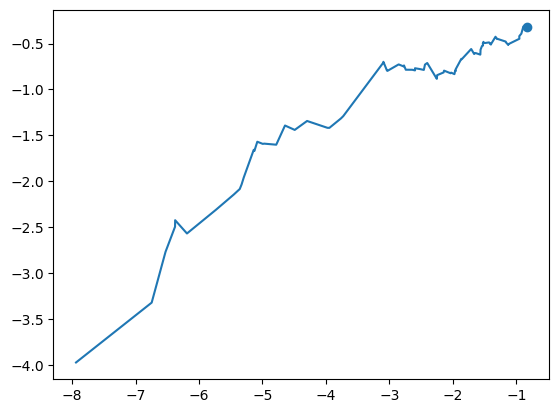

In [5]:
plt.figure()
plt.plot(history[:, 0], history[:, 1])
plt.scatter(history[-1, 0], history[-1, 1])
plt.show()

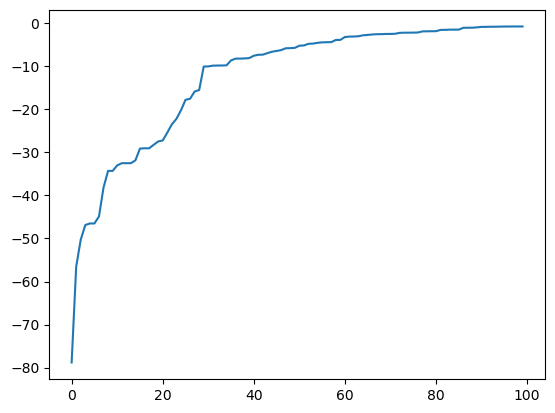

In [13]:
plt.figure()
loss_history = [convex_forward(None, {"vars" : torch.from_numpy(params)}) for params in history]
plt.plot(loss_history)
plt.show()